In [1]:
# Distributed under the "STEINWURF RESEARCH LICENSE 1.0".
# See accompanying file LICENSE.rst or
# http://www.steinwurf.com/license.html

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import kodo

# Overhead Due to Linear dependencies - A practical view

In our book chapter we derived the analytical expressions of the overhead of RLNC due to linear dependencies. In this notebook, we will use KODO. We will show with a practical implementation where the linear dependencies occur during the transmission process.

We define the generation size and the size of the packets

In [3]:
symbols = 32
symbol_size = 160

## Binary field size

Lets create the factories and the encoder

In [4]:
field = kodo.field.binary

# In the following we will make an encoder/decoder factory.
# The factories are used to build actual encoders/decoders
encoder_factory = kodo.RLNCEncoderFactory(field, symbols, symbol_size)
encoder = encoder_factory.build()
encoder.set_systematic_off()

decoder_factory = kodo.RLNCDecoderFactory(field, symbols, symbol_size)

# Create some data to encode. In this case we make a buffer
# with the same size as the encoder's block size (the max.
# amount a single encoder can encode)
data_in = bytearray(os.urandom(encoder.block_size()))

# Assign the data buffer to the encoder so that we may start
# to produce encoded symbols from it
encoder.set_const_symbols(data_in)

# Create the data buffer we will give to the decoder
data_out = bytearray(encoder.block_size())

Let us count the number of linear dependant packets received at each rank of the decoder using a python list

In [5]:
print("Processing")

runs = 5000 # We run the encoder-decoder 1000 times to accumulate statistics
linear_dependant_at_rank = []

for i in range(runs):
    decoder = decoder_factory.build()
    decoder.set_mutable_symbols(data_out)
    prev_rank = 0
    while not decoder.is_complete():
        # Generate an encoded packet
        packet = encoder.write_payload()

        # Pass that packet to the decoder
        decoder.read_payload(packet)

        # If the rank did not increase, it indicates a linear dependent packet.
        # We accumulate the ranks at which a linear dependent packet was received.
        if not decoder.rank() > prev_rank:
            linear_dependant_at_rank.append(decoder.rank())
        prev_rank = decoder.rank()

print("Processing finished")

Processing
Processing finished


### Histogram of the linear dependent packets received

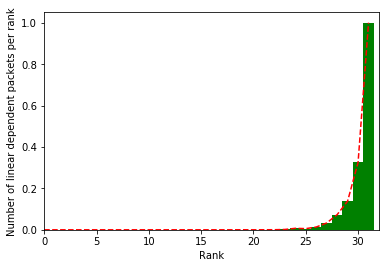

In [6]:
histogram, ranks = np.histogram(linear_dependant_at_rank,\
                                bins=[rank for rank in range(symbols + 1)])
histogram = np.divide(histogram, float(runs))

fig, ax = plt.subplots(1,1)

plt.plot(ranks[:symbols], histogram, 'r--')
plt.bar(ranks[:symbols], histogram, facecolor='green', width=1.0, align='center')
plt.xlim(0, symbols)


plt.xlabel('Rank')
plt.ylabel('Number of linear dependent packets per rank')

plt.show()

### Plot analysis

Why are the linear dependent packets appearing at the end of the transmission?

This is a question that we discussed in our book chapter. The probability that a packet is not innovative for the decoder is
$$P_{r \rightarrow r} = \frac{1}{2^{g-r}}\: ,$$
where $r$ is the rank of the decoder. This probability $P_{r \rightarrow r}$ increases when the rank increases. For the last packet, i.e., when the decoder is at rank 31, the probability that the next transmission is not innovative is $\frac{1}{2}$. This means that on average, to increase the rank from 31 to 32, two packets are needed. Out of these two packets, one is innovative, and the second one is linear dependent. Therefore, in the histogram, you can see that there is on average one linear dependent packet before the decoder gets the full rank.



#### NOTE:
The sum of the height of the bars of the histogram is approximately $1.6$. This is the value calculated analitically in the book chapter and the other jupyter notebook.

In [7]:
histogram.sum()

1.5987999999999998

## What about a bigger field size - $GF(2^8)$

In [8]:
field = kodo.field.binary8

In [9]:
encoder_factory = kodo.RLNCEncoderFactory(field, symbols, symbol_size)
encoder = encoder_factory.build()

decoder_factory = kodo.RLNCDecoderFactory(field, symbols, symbol_size)

# Assign the data buffer to the encoder so that we may start
# to produce encoded symbols from it
data_in = bytearray(os.urandom(encoder.block_size()))
encoder.set_const_symbols(data_in)

data_out = bytearray(decoder.block_size())

print("Processing")

runs = 5000      # We run the encoder-decoder a number of times to accumulate statistic
linear_dependant_at_rank = []

for i in range(runs):
    decoder = decoder_factory.build()
    decoder.set_mutable_symbols(data_out)
    prev_rank = 0
    while not decoder.is_complete():
        # Generate an encoded packet
        packet = encoder.write_payload()

        # Pass that packet to the decoder
        decoder.read_payload(packet)

        # If the rank did not increase, it indicates a linear dependent packet.
        # We accumulate the ranks at which a linear dependent packet was received.
        if not decoder.rank() > prev_rank:
            linear_dependant_at_rank.append(decoder.rank())
        prev_rank = decoder.rank()

print("Processing finished")

Processing
Processing finished


### Histogram of the linear dependent packets received

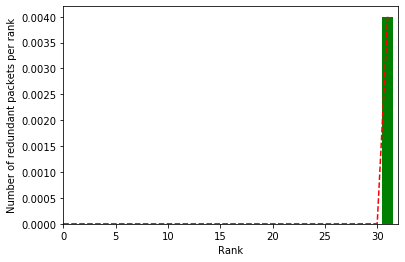

In [10]:
histogram, ranks = np.histogram(linear_dependant_at_rank,\
                                bins=[rank for rank in range(symbols + 1)])
histogram = np.divide(histogram, float(runs))

fig, ax = plt.subplots(1,1, sharey=True)

plt.plot(ranks[:symbols], histogram, 'r--')
plt.bar(ranks[:symbols], histogram, facecolor='green', width=1.0, align='center')
plt.xlim(0, symbols)

plt.xlabel('Rank')
plt.ylabel('Number of redundant packets per rank')

plt.show()

### Plot analysis

In this case, the probability of a non innovative packet is
$$P_{r \rightarrow r} = \frac{1}{256^{g-r}}\: .$$
This is a very small number. Before the last transmission ($P_{r \rightarrow r} =\frac{1}{256}$). And all the previous transmissions before that have the same probability to a certain power (an even smaller number). Therefore, the linear dependencies in this case occur most likely at the last transmission only, and they are negligible.

The tail behaviour is negligible at higher field size.

**Note** that the y-axis range is different in both graphs


#### NOTE:
The sum of the height of the bars of the histogram is approximately $0.0039$

In [11]:
histogram.sum()

0.004